Dataset: https://www.kaggle.com/datasets/uciml/adult-census-income/data

This dataset is the Adult Census Income dataset from the UCI machine learning repository and the main goal of the dataset is to predict whether a person's annual income is >50K based on their demographic and employment information. It contains about 32,000+ people's data and 14-15 attributes describing each person. The target variable is the binary label, <=50K and >50K. It has features related to demographic, education, status, and employment information. The fnlwgt variable is the census final weight, it represents how many people a record stands for which is used in survey statistics.

Part 1

In [1]:
import numpy as np

class NeuralNetwork:
    '''
    Parameters:
      layer_sizes: network architechture, each element represents the number of neurons in that layer
      learning_rate: step size used during gradient descent updates
    '''
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.parameters = {} # stores weights and biases
        self._initialize_parameters()

    # a. initialization method
    # initializes weights and biases for each layer of nn
    def _initialize_parameters(self):
        np.random.seed(42)
        L = len(self.layer_sizes) # num layers with input
        for l in range(1, L):
            # He initialization for relu
            self.parameters['W'+str(l)] = np.random.randn( # weight matrix for each layer
                self.layer_sizes[l], self.layer_sizes[l-1]
            ) * np.sqrt(2 / self.layer_sizes[l-1])
            self.parameters['b'+str(l)] = np.zeros((self.layer_sizes[l], 1)) # bias vector for each layer

    # activation functions
    # turn negative values to 0 to help learn non-linear patterns
    '''
    Applies reLU activation

    Parameters:
      Z: linear output before activation

    Returns:
      activated output where negative values set to 0
    '''
    def _relu(self, Z):
        return np.maximum(0, Z)

    # gradient flows when neuron is active
    '''
    Computes derivative of ReLU activation

    Parameters:
      Z: linear output before activation

    Returns:
      gradient mask
        1 where Z > 0, else 0
    '''
    def _relu_derivative(self, Z):
        return (Z > 0).astype(float)

    # output layer
    # outputs probability between 0 and 1 for binary classification
    '''
    Applies sigmoid activation

    Parameters:
      Z: linear output before activation

    Returns:
      values between 0 and 1 - probability array
    '''
    def _sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    '''
    Computes derivative of sigmoid activation

    Parameters:
      A: sigmoid output

    Returns:
      gradient of sigmoid array
    '''
    def _sigmoid_derivative(self, A):
        return A * (1 - A)

    # b. forward propagation
    # computes predictions
    '''
    Paramters:
      X: input data

    Returns:
      AL: final output probability array
      cache: stores intermediate values - Z and A for each layer
    '''
    def forward(self, X):
        cache = {'A0': X} # storing for backward propogation
        L = len(self.layer_sizes) - 1

        # for hidden layer
        for l in range(1, L):
            Z = np.dot(self.parameters['W'+str(l)], cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # linear combo before activation
            A = self._relu(Z) # activation output
            cache['Z'+str(l)] = Z
            cache['A'+str(l)] = A

        # for output layer
        ZL = np.dot(self.parameters['W'+str(L)], cache['A'+str(L-1)]) + self.parameters['b'+str(L)]
        AL = self._sigmoid(ZL) # predicted probability
        cache['Z'+str(L)] = ZL
        cache['A'+str(L)] = AL

        return AL, cache

    # cost function - binary cross-entropy
    '''
    Parameters:
      AL: array (1, m) - predicted probabilities
      Y: array (1, m) true labels

    Returns:
      loss value
    '''
    def cost(self, AL, Y):
        m = Y.shape[1] # num training exampels
        # bianary ce loss value
        loss = -1/m * np.sum(Y*np.log(AL+1e-8) + (1-Y)*np.log(1-AL+1e-8))
        return np.squeeze(loss)

    # backward propagation
    # chain rule to compute gradients
    '''
    Parameters:
      cache: stored forward pass values
      AL: predictions array
      Y: true labels array

    Returns:
      gradients for each layer (dW, db)
    '''
    def backward(self, cache, AL, Y):
        gradients = {}
        m = Y.shape[1]
        L = len(self.layer_sizes) - 1

        dZL = AL - Y  # simplified derivative for sigmoid + BCE
        gradients['dW'+str(L)] = 1/m * np.dot(dZL, cache['A'+str(L-1)].T) # gradient of weights
        gradients['db'+str(L)] = 1/m * np.sum(dZL, axis=1, keepdims=True) # gradient of bias

        # hidden layers
        dA_prev = np.dot(self.parameters['W'+str(L)].T, dZL) # error passed to previous layer

        for l in reversed(range(1, L)):
            dZ = dA_prev * self._relu_derivative(cache['Z'+str(l)]) # error after relu derivative
            gradients['dW'+str(l)] = 1/m * np.dot(dZ, cache['A'+str(l-1)].T)
            gradients['db'+str(l)] = 1/m * np.sum(dZ, axis=1, keepdims=True)

            if l > 1:
                dA_prev = np.dot(self.parameters['W'+str(l)].T, dZ)

        return gradients

    # gradient descent update
    # move weight in direction reducing loss
    '''
    Updates weights and biases using gradient descent

    Parameters:
      gradients: gradients from backwards
    '''
    def update_parameters(self, gradients):
        L = len(self.layer_sizes) - 1
        for l in range(1, L+1):
            self.parameters['W'+str(l)] -= self.learning_rate * gradients['dW'+str(l)]
            self.parameters['b'+str(l)] -= self.learning_rate * gradients['db'+str(l)]

    # training full batch
    # using all training data each step - slow
    '''
    Parameters:
      X: training inputs array
      Y: training lables array
      epochs: num of passes through dataset
    '''
    def train(self, X, Y, epochs=1000):
        for i in range(epochs):
            AL, cache = self.forward(X)
            cost = self.cost(AL, Y)
            gradients = self.backward(cache, AL, Y)
            self.update_parameters(gradients)

            if i % 100 == 0:
                print(f"Epoch {i}, Cost: {cost:.4f}")

    # mini-batch training
    # using small chunks of data
    '''
    Parameters:
      X: training inputs array
      Y: training labels array
      epochs: num training iterations
      batch_size: num samples per mini-batch
    '''
    def train_minibatch(self, X, Y, epochs=100, batch_size=64):
        m = X.shape[1]

        for epoch in range(epochs):
            permutation = np.random.permutation(m) # shuffle data
            # split into batches
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]

            # train each batch
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[:, i:i+batch_size]
                Y_batch = Y_shuffled[:, i:i+batch_size]

                AL, cache = self.forward(X_batch)
                gradients = self.backward(cache, AL, Y_batch)
                self.update_parameters(gradients)

            if epoch % 10 == 0:
                AL_full, cache_full = self.forward(X)
                cost = self.cost(AL_full, Y)
                print(f"Epoch {epoch}, Cost: {cost:.4f}")

    # prediction
    # if p > 0.5 - class 1 else class 0
    '''
    Parameters:
      X: input data array
      threshold: classification cutoff

    Returns:
      predicted class labels - 0 or 1
    '''
    def predict(self, X, threshold=0.5):
        AL, cache = self.forward(X)
        return (AL > threshold).astype(int)

The NeuralNetwork class is building a neural network from scratch using only NumPy. The network learns by forward pass to make predictions, then computes loss, then performs a backward pass to compute gradients, and then updates the weights. It is implemented using matrix multiplication, which allows samples in a batch to be processed at once instead of looping through examples individually. This makes training efficient using NumPy's linear algebra optimization.

First, initialization sets up the neural network structure with layer sizes, how big each weight update step is, and storing weights and biases. Then, initializing parameters creates weights and biases for each layer. ReLU makes half the negative inputs 0, so the variance of activations gets cut in half. He initialization is a method for choosing the starting weights of a neural network so the learning stays stable when using the ReLU activation. Instead of random numbers, they are scaled carefully. It keeps the size of variance about the same as they pass through the layers. Without this, the gradients either get smaller or too big, vanishing or exploding. The bias is initialized to 0 because the symmetry is broken by the random weights.

ReLU zeroes out negative activations, which reduces the expected variance of activations. He initialization compensates for this effect to keep variance stable across layers. This helps the network learn non-linear patterns. The derivative ensures the gradient flows only when the neuron is active. The sigmoid function is for the outer layer, and it outputs probability between 0 and 1, used for binary classification.

Forward propagation computes predictions for each hidden layer and the output layer. The Z and A values are stored for later use in backward propagation. Without storing them, the chain rule would not be able to be applied.

The cost function uses binary cross entropy to measure how wrong the predictions are; the lower the cost, the better the model. The backward propagation uses the chain rule to compute the gradient. The gradients represent how much each weight contributes to the error. The output layer gradient is a simplified derivative for sigmoid and cross entropy. This is a shortcut for the derivative of the loss function because the output activation is sigmoid and the loss is binary cross entropy. Binary cross entropy is used because it works well with sigmoid outputs and avoids the vanishing gradient problem that occurs if mean squared error is used for classification.

For the hidden layers, it has to move backward first, then compute the gradients again for the process of learning. The update parameters step is gradient descent, which is where the weights move in the direction that reduces loss.

The training is done on full batch, where each epoch does forward pass, computes cost, backprop, and updates the weights. Here, all the training data is used for each step, which is slow. I incorporated mini-batch gradient descent as a version of gradient descent to improve the efficiency in runtime. Instead of using all the data, it uses small chunks. It first shuffles the data and splits it into batches, then trains on each batch. It provides a balance between stable updates in full batch and fast but noisy updates in stochastic gradient descent. This is better because it is faster and converges quicker.

For the predictions, if the probability is > 0.5 it is in class 1; else it is in class 0.

Citations:
https://www.geeksforgeeks.org/deep-learning/kaiming-initialization-in-deep-learning/

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("adult.csv")

# converting ? missing values to nan
df.replace(" ?", np.nan, inplace=True)
df.dropna(inplace=True)

# seperating label
Y = (df["income"] == ">50K").astype(int).values.reshape(-1, 1)
X_df = df.drop("income", axis=1)

# one-hot encode features
X_df = pd.get_dummies(X_df)
X = X_df.values # convert to np

# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit on training data
X_test = scaler.transform(X_test)

# transpose to match forward prop
X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = Y_train.T, Y_test.T

The dataset needs to be preprocessed before training to avoid leakage. First, the missing values are stored as question marks instead of Nan, so they converted to Nan. Neural networks cannot handle missing values, so the rows that contain missing data are dropped. Income is the target variable and it is seperated using >50K. If >50K it becomes true, else becomes false. If it has high income it becomes 1 and else low income becomes 0. The label column is removed to avoid 'cheating'. The categorical features are one-hot encoded becuase neutral networks need numbers and not text. Since the NN is written in scratch with numpy, it has to be converted so the datafram becomes a matrix. The data is split into 80% training and 20% testing and split before scaling to avoid data leakage. The features are then scaled because NN works better when the inpts are centered. The scaled feature is the $(x - mean) / std$ and fits on training data and uses the same scaling on test data. This prevents test data from leaking into training data. The NN expects X and y but since sklearn outputs (m, feautures) it is transposed to match the match used in forward propogation.

In [3]:
# train model
neural_network = NeuralNetwork([X_train.shape[0], 20, 1], learning_rate=0.01)

print("Mini-batch Gradient Descent Training")
neural_network.train_minibatch(X_train, Y_train, epochs=100, batch_size=64)

preds = neural_network.predict(X_test)
accuracy = np.mean(preds == Y_test) * 100
print("Test Accuracy:", accuracy)

Mini-batch Gradient Descent Training
Epoch 0, Cost: 0.3990
Epoch 10, Cost: 0.3214
Epoch 20, Cost: 0.3107
Epoch 30, Cost: 0.3049
Epoch 40, Cost: 0.3013
Epoch 50, Cost: 0.2986
Epoch 60, Cost: 0.2966
Epoch 70, Cost: 0.2946
Epoch 80, Cost: 0.2929
Epoch 90, Cost: 0.2913
Test Accuracy: 84.76892369107938


The Adult census income dataset contains over 30,000 observations which makes full-batch gradient descent slow. Using all the training data to compute gradients before every update can be stable and decrease the loss steadily, but for this dataset it is very slow because the dataset is large. It has one update per epoch and needs more memory, so training would take a long time. Stochastic gradient descent uses one example at a time which can be faster but it also gives noisy updates. The Adult census income dataset contains over 30,000 observations which makes full-batch gradient descent slow. Using all the training data to compute gradients before every update can be stable and decrease the loss steadily, but for this dataset it is very slow because the dataset is large. It has one update per epoch and needs more memory, so training would take a long time. Stochastic gradient descent uses one example at a time which can be faster but it also gives noisy updates. Mini-batch graident descent combines both full-batch and SGD using both the advantages. It learns faster because the weights are updated many times per epoch so learning happens sooner than full batch. It is more stable than SGD because it averages gradients for each batch from multiple samples which reduces noise. It updates weights using smaller subsets of data which reduces the computation per update and accelerates convergence. Looking test accuracy of the mini-batch gradient descent shows that the model correcly predicts income about 85% of the time. This shows that the model learning meaningful patterns and wasn't just memorizing the training data.

Part 2

Task 1

For part 2, I am choosing Pytorch as the deep learning framework. I have worked lightly with Pytorch before but still did some research to learn more about it.

I needed the PyTorch Beginner Model Tutorial resource to learn how to define a neural network class using nn.Module, the foundation of any PyTorch model. It shows how layers like nn.Linear are created and stored inside the model, replacing the manual weight matrices I used the NumPy version. It also explained how the forward() function defines forward propagation, which is where inputs move through the layers to produce predictions. It also showed how to structure the training loop, including how to call the loss function, perform backpropagation using loss.backward(), and update parameters with an optimizer. This resource was needed for implementing the 2-layer NN because it showed how the model, loss, and optomizer components connect during training.

The PyTorch Autograd documentation explained how automatic differentiation works, which replaces the manual backpropagation I used with NumPy. In PyTorch, gradients are computed automatically when tensors have requires_grad=True, and the framework tracks operations to build a computation graph during the forward pass. This resource showed what happens when calling loss.backward(), how gradients are stored in .grad, and why gradients must be cleared each iteration using optimizer.zero_grad(). This resource was needed because it shows how Pytorch calculates derivatives and it applies the chain rule across layers with autograd.

The PyTorch Loss Functions documentation explains how to measure prediction error in a neural network. I needed this resource to learn how to select and apply the correct loss function for a 2-layer neural network, such as nn.BCELoss for binary classification. This shows how the loss function provides the feedback signal that tells the network how well it is performing and guides the gradient calculations during backpropagation. This resource was needed because it showed how to quantify errors correctly and connect the loss to the training process.

The PyTorch Optimizer documentation explains how to update the model’s parameters using computed gradients. I needed this resource to learn how to use optimizers such as optim.SGD or optim.Adam to perform the gradient descent step automatically, replacing manual weight updates done in NumPy. This shows that even with correct gradients, the network cannot learn unless the optimizer applies them properly to the model parameters. This resource was needed because it showed how to update weights during training.

The PyTorch tensors documentation explains how PyTorch tensors are the core data structure of the framework and are required to store inputs, model parameters, and intermediate computations. Unlike NumPy arrays, tensors support GPU acceleration and automatic differentiation when requires_grad=True. During forward propagation, tensors carry data through each layer, and during backward propagation, PyTorch uses them to track operations in the computation graph. This resource was necessary because tensors make both forward and backward propagation possible within PyTorch.

Citations:
1. PyTorch Beginner Model Tutorial https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
2. PyTorch Autograd Documentation https://docs.pytorch.org/docs/stable/autograd.html
3. PyTorch Loss Functions https://docs.pytorch.org/docs/stable/nn.html
4. PyTorch Optimizer Documentation https://docs.pytorch.org/docs/stable/optim.html
5. PyTorch Tensors Documentation https://docs.pytorch.org/docs/stable/tensors.html

Task 2

Missing values per column:
 age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64
(32561, 15)


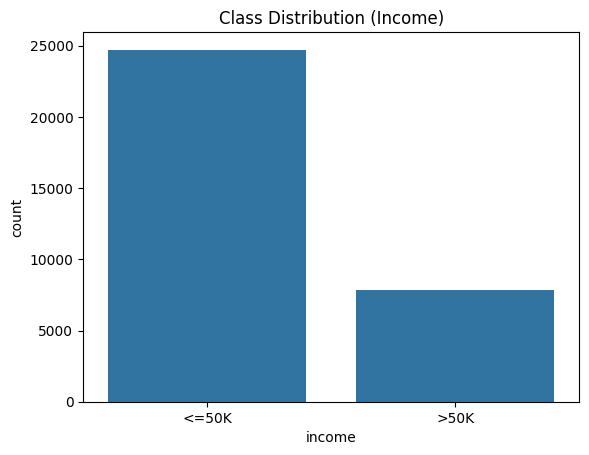

Class proportions:
 income
0    0.75919
1    0.24081
Name: proportion, dtype: float64


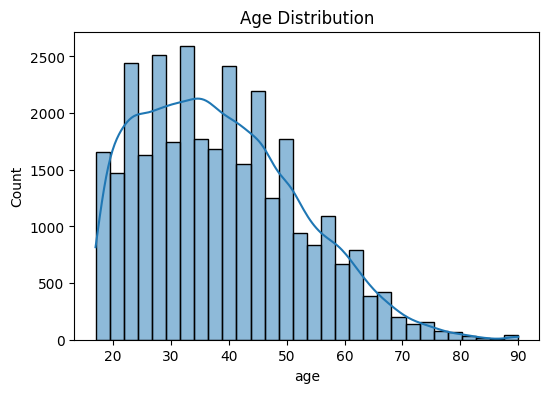

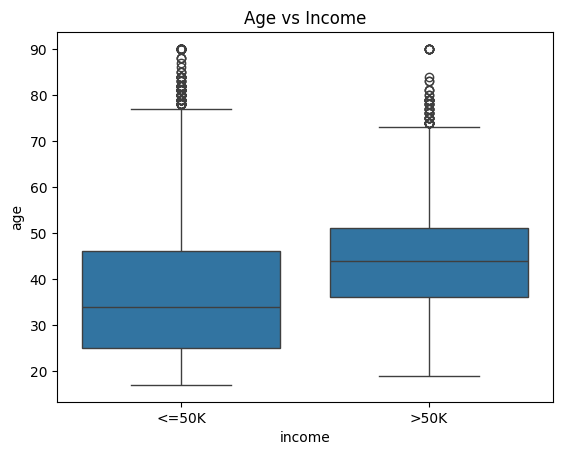

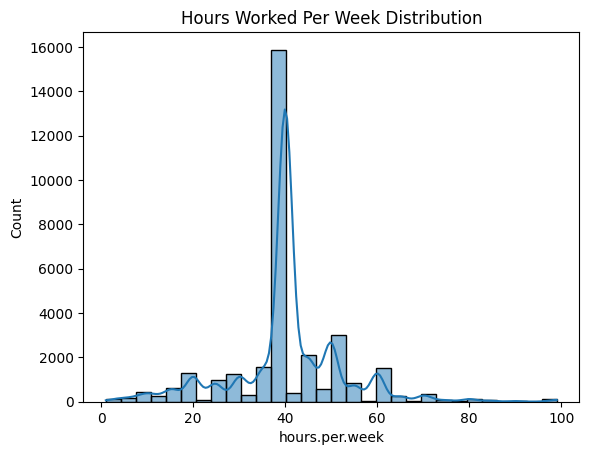

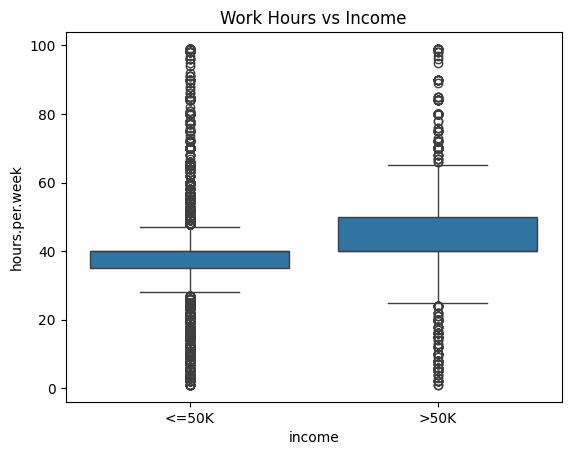

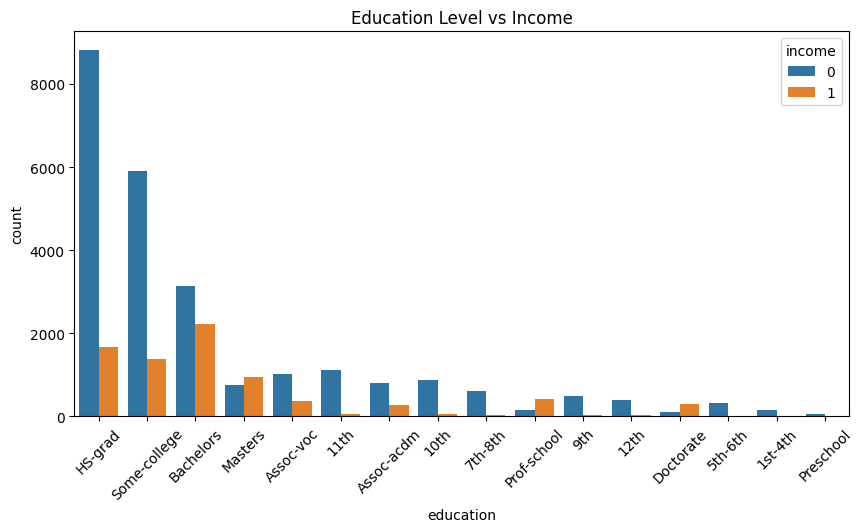

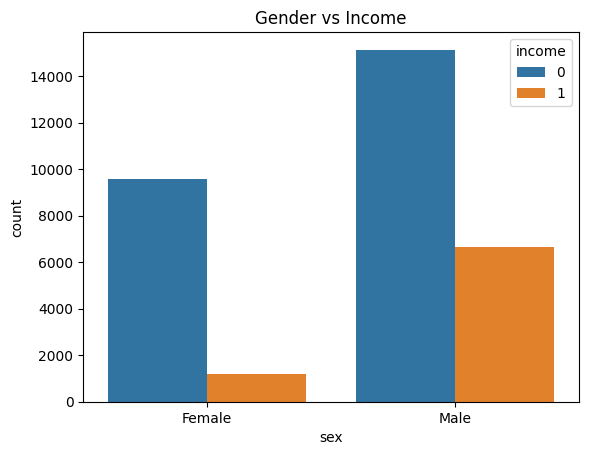

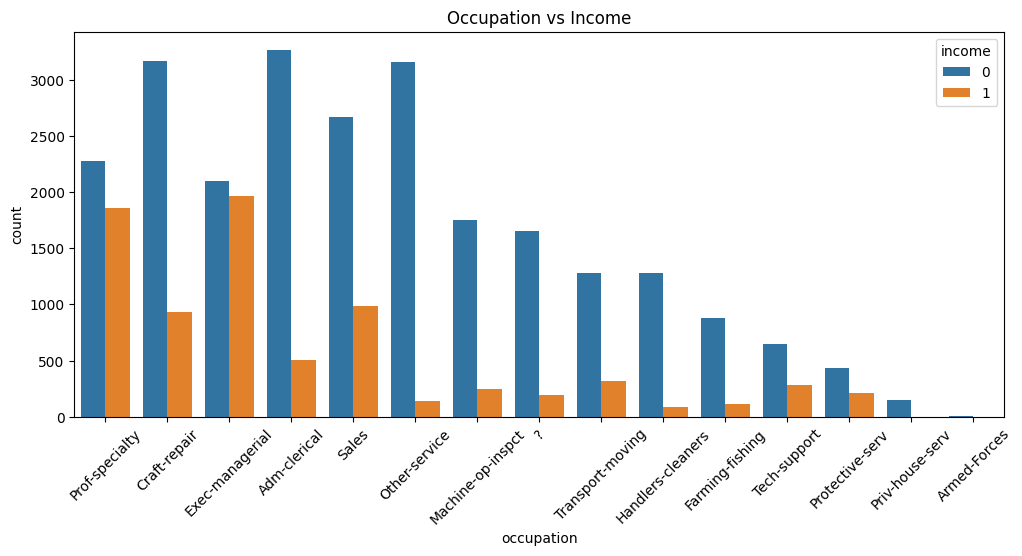

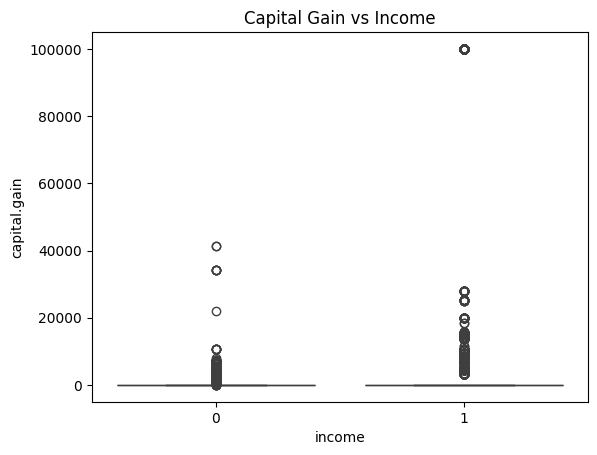

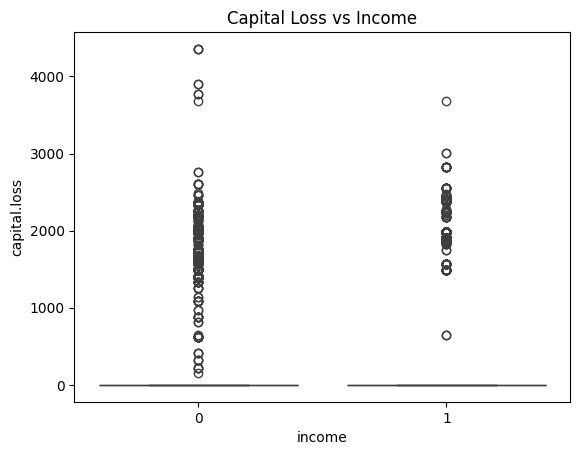

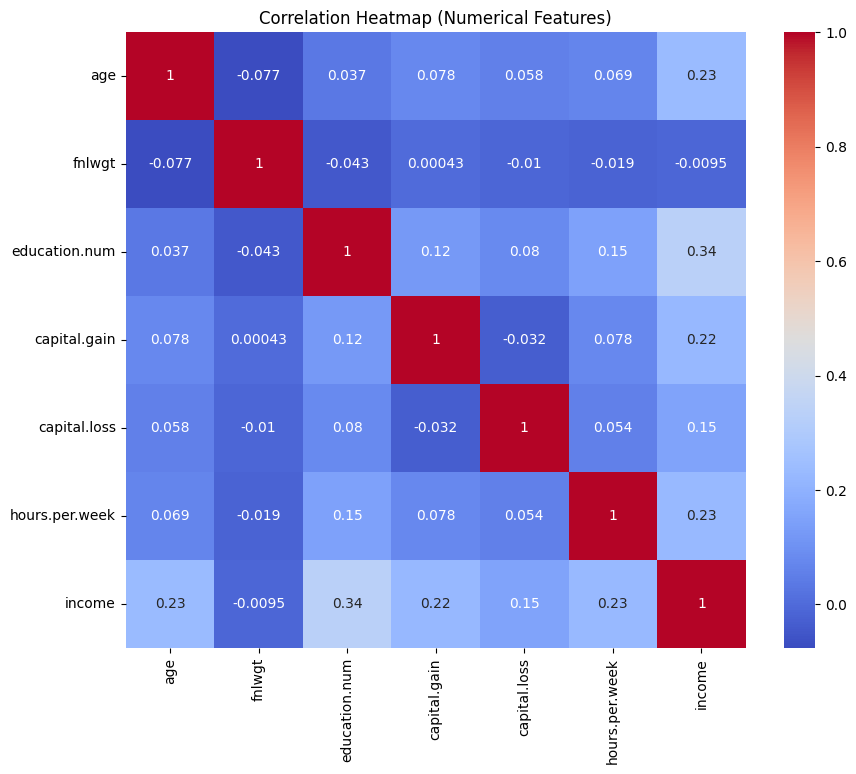

Mean values grouped by income:

              age        fnlwgt  education.num  capital.gain  capital.loss  \
income                                                                       
0       36.783738  190340.86517       9.595065    148.752468     53.142921   
1       44.249841  188005.00000      11.611657   4006.142456    195.001530   

        hours.per.week  
income                  
0            38.840210  
1            45.473026  


In [4]:
# 1. EDA
import matplotlib.pyplot as plt
import seaborn as sns

# missing values in columns
print("Missing values per column:\n", df.isnull().sum())

# drop rows with missing values
df.dropna(inplace=True)

# label - >50K = 1 <=50K = 0
df['income'] = (df['income'] == '>50K').astype(int)

print(df.shape)

# checking if dataset is imbalanced
sns.countplot(x='income', data=df)
plt.title("Class Distribution (Income)")
plt.xticks([0,1], ["<=50K", ">50K"])
plt.show()

print("Class proportions:\n", df['income'].value_counts(normalize=True))


# age analysis
# age spread and relationship with income
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

# comparing age by income group
sns.boxplot(x='income', y='age', data=df)
plt.title("Age vs Income")
plt.xticks([0,1], ["<=50K", ">50K"])
plt.show()

# checking if high earners work more hours
sns.histplot(df['hours.per.week'], bins=30, kde=True)
plt.title("Hours Worked Per Week Distribution")
plt.show()

sns.boxplot(x='income', y='hours.per.week', data=df)
plt.title("Work Hours vs Income")
plt.xticks([0,1], ["<=50K", ">50K"])
plt.show()

# checking education vs income
plt.figure(figsize=(10,5))
sns.countplot(x='education', hue='income', data=df,
              order=df['education'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Education Level vs Income")
plt.show()

# possible income distribution differences with gender
sns.countplot(x='sex', hue='income', data=df)
plt.title("Gender vs Income")
plt.show()

# which jobs have more high earners
plt.figure(figsize=(12,5))
sns.countplot(x='occupation', hue='income', data=df,
              order=df['occupation'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Occupation vs Income")
plt.show()

# capital gain + loss
sns.boxplot(x='income', y='capital.gain', data=df)
plt.title("Capital Gain vs Income")
plt.show()

sns.boxplot(x='income', y='capital.loss', data=df)
plt.title("Capital Loss vs Income")
plt.show()

# correlation heatmap
# relationships between numeric features
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# summary stats
# compare average values for <=50K vs >50K

print("Mean values grouped by income:\n")
print(df.groupby('income').mean(numeric_only=True))

I performed a detailed EDA on this dataset to make sure I clearly understand all the information thoroughly. Looking at the class distribution (income) and class proportions, it shows that the dataset is moderately imbalanced with about 76% of individuals earning <=50K and 24% earning >50K. This means the model could get high accuracy by always predicting the majority class so the evaluation metrics would be more meaningful than just accuracy. The age distribution histogram is right-skwed with most individuals beterrn 20 and 50 years with a fewer older. This shows that the dataset mainly represents working-age adults and suggests age could be a factor of income through work experience. The age vs income boxplot shows that people earing >50K are older on average with a higher median and upper quartile. This supports a strong positive relationship between age experience and income. The hours worked per week distribution is very high at 40 hours per week which is the standard full time work hours, with is some variable in the working hours. The work hours per week vs income shows that working longer hours is associated with income but not the only factor with the outliers. The education level vs income shows higher education levels have a much larger proportion of people earning >50K comapared to education which shows education is one of the strongest predictors of income in the dataset. Gender vs income shows significantly more men in the >50K category than women. This suggests a gender gap within the dataset and gender may be a predictive feature, with ethical considerations. The occupation vs income shows professional and managerial occupations have higher proportions of >50K earners and service and manual jobs cluster in <=50K. Occupation shows a soscioeconomic status difference between the people in the dataset. Capital gain vs income shows that most individuals have zero capital gain, but large gains show in the >50K group which shows the feature is highly skewed. However, this is an improtant predicted but could dominate the model if not normalized. The capital loss vs income is similar to capital gain but with a weaker effect, non-zero losses are more common among higher earners, suggesting investment activity is linked to income. The correlation heatmap shows that income is most corralted with education.num, age, hours.per.week and capital gain. The mean values grouped by income shows higher earners are older, more educated, work longer hours, and have much higher capital gain and losses.

In [5]:
# 2. train-dev-test split

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split dataset into train 70% temp 30%
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

# split temp equally into dev 15% test 15%
X_dev, X_test, Y_dev, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42
)

# shapes
print("Train set:", X_train.shape)
print("Dev set:", X_dev.shape)
print("Test set:", X_test.shape)

scaler = StandardScaler()

# feature normalization
X_train = scaler.fit_transform(X_train) # learn mean & std
X_dev = scaler.transform(X_dev) # use same scaling
X_test = scaler.transform(X_test)

# convert numpy arrays to pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
#Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1) # (N,1)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
#Y_dev = torch.tensor(Y_dev, dtype=torch.float32)
Y_dev = torch.tensor(Y_dev, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
#Y_test = torch.tensor(Y_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

Train set: (22792, 108)
Dev set: (4884, 108)
Test set: (4885, 108)


This code splits the full dataset into 70% for training to help the model learn the patterns. The rest 30% is put into temp which is held aside for evaluation. The temp is split into dev and test after. 15% goes to dev, validation, which tunes the hyperparameters. The other 15% goes into testing for final unbiased evaluation. This 3 way split is important because the train is used to learn weights, the dev is used to choose learning rates and the test is used for the final performance. The features are then normalized which makes each features mean 0 and std 1. This is needed for the gradient descent neural network trains with, and works best when the features are all on similar scales. Without scaling one feature dominates and training becomes slow and unstable. Only the training data is fit because it prevents leakage as dev would leak information from the validation data into the training data. There is conversion to pytorch tensors because pytorch cannot train on numpy arrays. Neural networks need tensors for autograd and model operations. It has to be float32 because neural networks require float tensors because gradients are real number, with integers the gradients break. The change to add .view(-1,1) was to make sure there was shape compatibility. Before, when these were not added, the model output would not work because BCE was expecting the tensors to match. This fixed the optimizer below because mismatched shapes can break learning.

In [6]:
# 3. forward propagation
class TwoLayerNN(nn.Module):
    '''
    Parameters:
      input_size: num input features in each sample
      hidden_size: num neurons in hidden layer
                   hyperparameter determines model capacity
    '''
    def __init__(self, input_size, hidden_size):
        super(TwoLayerNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size) # hidden layer
                                            # hyperparameter number of neurons
        self.relu = nn.ReLU() # activation for hidden layer
        self.output = nn.Linear(hidden_size, 1) # output layer
        self.sigmoid = nn.Sigmoid() # activation for output layer

    '''
    Parameters:
      x: torch.Tensor of shape (N, input_size)
                                N = num examples in batch
    Returns:
      torch.Tensor of shape (N, 1)
        predicted probabilities for positive class after applying sigmoid activation function
    '''
    def forward(self, x):
        z1 = self.hidden(x) # linear step
        a1 = self.relu(z1) # hidden activation
        z2 = self.output(a1) # linear step
        a2 = self.sigmoid(z2) # output activation
        return a2

For this part it implements the 2-layer fully connected neural network. Using pytorch, the neural network is inherited from nn.Module. The layers and hyperparameters are defined in the initialization with input_size being number of features in each data sample and the hidden_size being the number of neurons in the hidden layer. The hidden layer is a fully connected linear layer. The activation function for the hidden layer is ReLU which introduces non-linearity. This prevents vanishing gradients which is better for hidden layers and makes training faster. The output layer outputs a single value which means binary classification. The output activation function is sigmoid because it converts the output into a probability between 0 and 1. The forward propagation defines how the data moves through the network. There is then the hidden linear transformation and the hidden activation which adds non-linearity so the model can learn complex patterns. The output linear transformation and then the output activation which gives the final predicted probability.

In [7]:
# 4. compute final cost function

input_size = X_train.shape[1]
hidden_size = 20

model = TwoLayerNN(input_size, hidden_size)

# binary cross entropy loss
criterion = nn.BCELoss()

# forward pass - model makes predictions
outputs = model(X_train)   # predicted probabilities

# compute cost - loss value
# Y_train shape (N,1) to match outputs
loss = criterion(outputs, Y_train)

print("Current Loss:", loss.item())
                       # converting tensor to num

Current Loss: 0.7018280029296875


To compute the final cost, the model needs to be setup and computed with the loss function. The model is first set up with the number of features and number of neurons. The loss function is BCE loss (Binary Cross Entropy) which is used for binary classification when output is a probability, which is because of the sigmoid function. It then runs forward propagation and computes the cost with the model with the output model predictions and true labels. PyTorch calculates the BCE loss for each of the example and then averages. The loss is the average error across the batches.

In [8]:
# 5. implement gradient descent

import torch.optim as optim

# hyperparameters
input_size = X_train.shape[1]
hidden_size = 20
epochs = 100
batch_size = 64
learning_rate = 0.01

# training function for model using mini-batch gradient descent
'''
Parameters:
  model: pytorch neural network model
  X_train: tensor training features
  Y_train: tensor training labels
  optimizer: pytorch adam optimizer
  criterion: BCEloss function
  epochs: num full passes over dataset
  batch_size: size of mini-batches for gradient updates

Returns:
  loss_history: list of average loss per epoch
'''
def train_model(model, X_train, Y_train, optimizer, criterion, epochs=100, batch_size=64):
    """Train a PyTorch model using mini-batch gradient descent."""
    loss_history = []

    # helper function to generate mini-batches from data
    def get_batches(X, Y, batch_size):
        for i in range(0, X.size(0), batch_size):
            yield X[i:i+batch_size], Y[i:i+batch_size]

    for epoch in range(epochs):
        epoch_loss = 0
        # loop over mini-batches
        for X_batch, Y_batch in get_batches(X_train, Y_train, batch_size):
            optimizer.zero_grad() # clear previous gradients
            outputs = model(X_batch) # forward pass
            loss = criterion(outputs, Y_batch)
            loss.backward() # compute gradients - backward propagation
            optimizer.step() # update model parameters
            epoch_loss += loss.item() * X_batch.size(0)

        epoch_loss /= X_train.size(0)
        loss_history.append(epoch_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    return loss_history

# normalized inputs
# normalize training inputs
scaler = StandardScaler()
# fitting scalar data and transform
X_train_norm = torch.tensor(scaler.fit_transform(X_train.numpy()), dtype=torch.float32)
X_dev_norm = torch.tensor(scaler.transform(X_dev.numpy()), dtype=torch.float32)
X_test_norm = torch.tensor(scaler.transform(X_test.numpy()), dtype=torch.float32)

# model loss optomizer for normalized inputs
torch.manual_seed(42)
model_norm = TwoLayerNN(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer_norm = optim.Adam(model_norm.parameters(), lr=learning_rate)

print("Training on Normalized Inputs")
loss_history_norm = train_model(model_norm, X_train_norm, Y_train, optimizer_norm, criterion)

# unnormalized inputs (unscaled)
X_train_raw = X_train.clone()
X_dev_raw = X_dev.clone()
X_test_raw = X_test.clone()

# model loss optomizer for unscaled inputs
torch.manual_seed(42)
model_raw = TwoLayerNN(input_size, hidden_size)
optimizer_raw = optim.Adam(model_raw.parameters(), lr=learning_rate)

print("\nTraining on Unscaled Inputs")
loss_history_raw = train_model(model_raw, X_train_raw, Y_train, optimizer_raw, criterion)

Training on Normalized Inputs
Epoch 0, Loss: 0.3429
Epoch 10, Loss: 0.2979
Epoch 20, Loss: 0.2917
Epoch 30, Loss: 0.2869
Epoch 40, Loss: 0.2831
Epoch 50, Loss: 0.2806
Epoch 60, Loss: 0.2786
Epoch 70, Loss: 0.2760
Epoch 80, Loss: 0.2753
Epoch 90, Loss: 0.2774

Training on Unscaled Inputs
Epoch 0, Loss: 0.3429
Epoch 10, Loss: 0.2979
Epoch 20, Loss: 0.2918
Epoch 30, Loss: 0.2879
Epoch 40, Loss: 0.2838
Epoch 50, Loss: 0.2859
Epoch 60, Loss: 0.2783
Epoch 70, Loss: 0.2760
Epoch 80, Loss: 0.2753
Epoch 90, Loss: 0.2743


In this code I use Adam as the optimization algorithm as it adjusts the learning rate for each parameter automatically. It converges fast, works well without heavy tuning, and is able to handle noisy gradients. I used mini-batch training so it uses chunks of the data instead of the entire dataset, making training more efficient and less noisy than pure stochastic updates. For each mini-batch, a forward pass, loss computation, backward pass, and weight update are performed. The results of the normalized inputs show the loss decreasing consistently over the epochs from 0.3429 to around 0.2753 by epoch 80, with a small fluctuation at epoch 90 (0.2774). This shows that optimization is mostly stable and the model is making steady improvements near convergence, but there is a small increase at the end. The unscaled inputs show very similar starting loss and early behavior, however, there is a temporary increase at epoch 50 (0.2859), the model continues improving and ends with a slightly lower final loss (0.2743) compared to the normalized model. This shows that although gradients are slightly noisier at certain points, the model is still able to converge. The normalized model converged smoothly overall, while the unscaled input model showed minor fluctuations but reached comparable or slightly better performance. This happens because scaling features to zero mean and unit variance ensures balanced gradient updates, allowing the Adam optimizer to adjust parameters effectively. However, Adam is already adaptive to different feature scales, which explains why the performance difference between normalized and unscaled inputs is small. The loss decreases rapidly at first and then plateaus as the model approaches an optimum. Since training is non-deterministic, results vary slightly each run due to random weight initialization and mini-batch sampling, so to ensure fair comparison, I added a random seed.

Normalized Inputs
Dev Set Accuracy: 83.97%
Test Set Accuracy: 84.91%
Unscaled Inputs
Dev Set Accuracy: 84.13%
Test Set Accuracy: 84.77%


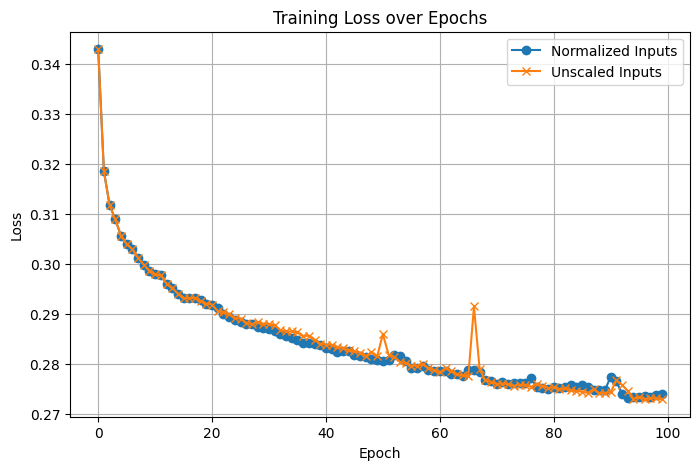

In [9]:
# 6. present results using test set

'''
Parameters:
  model: trained neural network model
  X_eval: input features for evaluation
  Y_eval: true labels to X_eval

Returns:
  classification accuracy as percentage
'''
def evaluate(model, X_eval, Y_eval):
    model.eval()
    with torch.no_grad():
        outputs = model(X_eval)
        preds = (outputs > 0.5).float()
        accuracy = (preds == Y_eval).float().mean()
    return accuracy.item() * 100

# normalized dev test results
dev_acc_norm = evaluate(model_norm, X_dev_norm, Y_dev)
test_acc_norm = evaluate(model_norm, X_test_norm, Y_test)
print("Normalized Inputs")
print(f"Dev Set Accuracy: {dev_acc_norm:.2f}%")
print(f"Test Set Accuracy: {test_acc_norm:.2f}%")

# unscaled dev test results
dev_acc_raw = evaluate(model_raw, X_dev_raw, Y_dev)
test_acc_raw = evaluate(model_raw, X_test_raw, Y_test)
print("Unscaled Inputs")
print(f"Dev Set Accuracy: {dev_acc_raw:.2f}%")
print(f"Test Set Accuracy: {test_acc_raw:.2f}%")

# plotting training losses
plt.figure(figsize=(8,5))
plt.plot(range(epochs), loss_history_norm, marker='o', label='Normalized Inputs')
plt.plot(range(epochs), loss_history_raw, marker='x', label='Unscaled Inputs')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

From the plot, it shows both curves almost overlapping for most of the training. The loss drops quickly at the beggining and then gradually flattens. The unscaled inputs have visible spikes around mid-training while the normalized curve is smoother. Normalization did improve training stability, but not dramatically. The dev test accuracy has less than 0.25% of a difference and normalized is slightly better on the test set. While SGD would have highlighted the benefits of normalization more strongly, Adam is stronger to feature scale differences. The experiment shows that although normalization stabilizes training, Adam’s adaptive learning rates reduce its impact on final performance.

Task 3

Description

For Task 2, hyperparameters were selected using a combination of heuristic guidelines and observation of training convergence. For the hyperparameters I chose hidden_size = 20, learning_rate = 0.01, batch_size = 64 and epochs = 100. I chose 20 neurons in the hidden layer as a balance between model capacity and overfitting risk. With too few neurons, the network could underfit and fail to learn the complex patterns in the data. Too many neurons could lead to overfitting and unnecessary computation. A learning rate of 0.01 was chosen based on typical rate for the Adam optimizer. It provides a good tradeoff between convergence speed and stability. Mini-batch gradient descent was used to  update weights while providing stochasticity to escape minimum and a batch size of 64 is also commonly used for tabular datasets. I trained the network for 100 epochs, which was good for convergence while avoiding overfitting. The training loss plateaued around this point for both normalized and unnormalized inputs.

Rationale

I used mini-batch gradient descent to update parameters in small batches. This approach combines both the stability of full-batch gradient descent with the speed and regularization effects of stochastic gradient descent. It also allows for efficient computation on larger datasets.

Regularization + why/why not

I did not include explicit regularization like L1/L2 or dropout because the dataset is moderate in size, and overfitting was not severe with the chosen hidden layer size. For larger networks or smaller datasets, regularization would be important to prevent overfitting.

Optimization algorithm + why/why not

I used the Adam optimizer, which adapts the learning rate for each parameter and combines the benefits of momentum and RMSProp. Adam accelerates convergence and is strong with the choice of initial learning rate. I also experimented with normalized vs unnormalized inputs. Normalizing the inputs significantly improved convergence speed and final accuracy because all features were on a similar scale, which helps gradient-based optimization algorithms perform better.